In [3]:
# Import functions for calculations
from functions import *
from mie_coated import *

# Tweak styles
mpl.rc('image', cmap='gray')

#Path to data
base_path = 'example-data/processed'

Load frames and form the detection images (Ibg = scattering, Ifbg = fluorescence)

In [4]:
#Image dimensions
dims = [2048, 1024]
#Load frames
I0, I, Ibg, Ig, Ii, If, Ifbg = load_frames(dims=dims, Ns_samples=5, 
            Nf_samples=3, Nm_samples=8, Nm_start=5, positions=[1, 2, 3], params=[20, 5],\
            base_path=base_path, scat_frames='Exp_particles_aligned', fluor_frames='fl_not_aligned')

c:\Users\ppark\Python Projects\ev_wgsm\functions.py:106: RuntimeWarning: invalid value encountered in true_divide
  A = np.maximum(I/bg, 1)
c:\Users\ppark\Python Projects\ev_wgsm\functions.py:107: RuntimeWarning: invalid value encountered in true_divide
  B = np.maximum(I0/bg0, 1)


Particle detection
1) Silica nanoparticles (SNPs)
2) Synthetic lipid vesicles (SVs)
3) EVs
4) After antibody binding (EV-specific, here PE-CD9/APC-CD41)
5) After antibody binding (anti-biotin)

In [5]:
#Scattering
thresh = [3, 1.5, 1.5, 1.5, 1.5]
L, Lbg = detect_particles(dims=dims, Ibg=Ibg, model='Max', thresh=thresh, disk_sizes=[2, 1, 7, 3], thickening=[8, 2])

#Fluorescence
Lf, Lfbg = detect_particles(dims=dims, Ibg=Ifbg, model='Max', thresh=[0.5]*Ifbg.shape[0], disk_sizes=[2, 1, 7, 3], thickening=[8, 2])

Plot scattering images and detected particles

C:\Users\ppark\AppData\Local\Temp\ipykernel_10248\2750861083.py:9: RuntimeWarning: invalid value encountered in true_divide
  p = np.nan_to_num(L[i, j] / L[i, j])
C:\Users\ppark\AppData\Local\Temp\ipykernel_10248\2750861083.py:12: RuntimeWarning: invalid value encountered in true_divide
  mask = np.nan_to_num(Lbg[i, j] / Lbg[i, j])


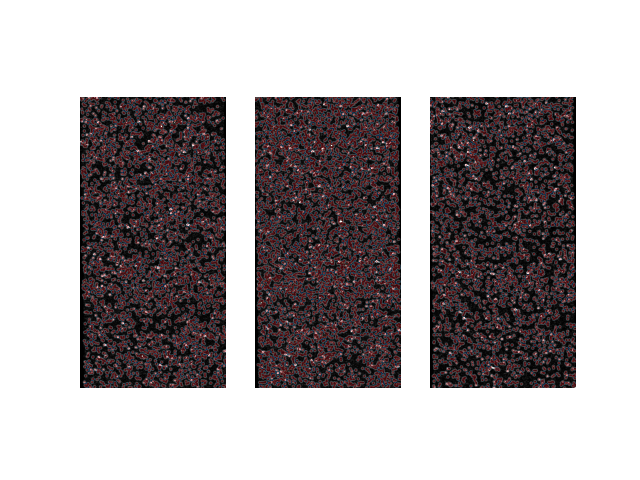

In [23]:
#Plot positions (scattering)
%matplotlib widget
fig, ax = plt.subplots(1, Ibg.shape[1])
ax = ax.flatten()

i = 2 #for EVs, i = 2
for j in range(Ibg.shape[1]):        
    ax[j].imshow(Ibg[i, j], vmin=0, vmax=5)
    p = np.nan_to_num(L[i, j] / L[i, j])
    ax[j].imshow(p.astype(np.float32), alpha = 0.5*p.astype(np.float32), cmap = 'Reds', vmin=0, vmax=1)

    mask = np.nan_to_num(Lbg[i, j] / Lbg[i, j])
    ax[j].imshow(mask.astype(np.float32), alpha = 0.5*mask.astype(np.float32), cmap = 'Blues', vmin=0, vmax=1)
    ax[j].imshow(L[i, j], alpha=0)
    ax[j].axis('off')

Calculate intensities of all particles

136906.04796521825
31604.97014925373
35083.54966307279


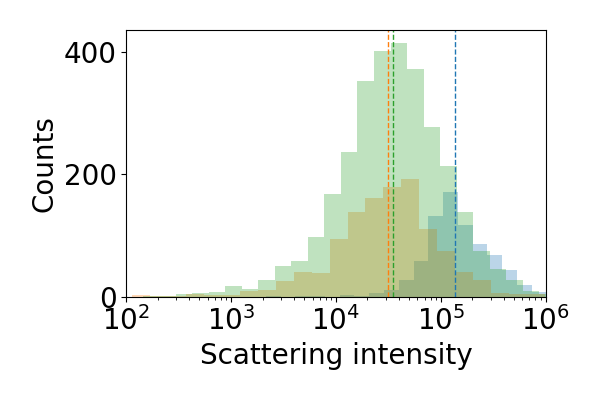

In [20]:
# Process intensities
Ints = np.empty((L.shape[0], L.shape[1]), dtype='object')
Ints_after_AB1 = np.empty((L.shape[0], L.shape[1]), dtype='object')
Ints_after_AB2 = np.empty((L.shape[0], L.shape[1]), dtype='object')
coords = np.empty((L.shape[0], L.shape[1]), dtype='object')
saturated = np.empty((L.shape[0], L.shape[1]), dtype='object')

for i in range(L.shape[0]):
    for j in range(L.shape[1]):
        Ints[i, j], coords[i, j], saturated[i, j] = calculate_intensities(I[2, j], L[i, j], Lbg[i, j])
        Ints_after_AB1[i, j], _, _ = calculate_intensities(I[3, j], L[i, j], Lbg[i, j])
        Ints_after_AB2[i, j], _, _ = calculate_intensities(I[4, j], L[i, j], Lbg[i, j])

%matplotlib widget
fig, ax = plt.subplots(figsize = (6,4))
plt.rcParams.update({'font.size': 20})

for i in range(L.shape[0]-2):
    Ints_EV_plot, logbins = plot_loghist(Ints[i, 0], 25)
    print(np.nanmedian(Ints_EV_plot))
    ax.hist(Ints_EV_plot, bins=logbins, alpha = 0.3)
    ax.set_xscale('log')
    ax.axvline(np.nanmedian(Ints_EV_plot), color = f'C{i}', linestyle='dashed', linewidth=1)
    ax.set_xlim(1e2, 1e6)
    ax.set_xlabel('Scattering intensity')
    ax.set_ylabel('Counts')
plt.tight_layout()

#Blue = SNPs
#Orange = Vesicles
#Green = EVs

Determine bound/unbound particles per frame
!! Only partial data is provided in the repository due to large file sizes !!

In [4]:
file = 'EV_binding'
frames_orig = tf.imread(f'{base_path}/{file}.tif')
Nframes = np.zeros((frames_orig.shape[0]-1, 2)).astype(int)

for i in range(1, frames_orig.shape[0]):
    
    Idet = reference_removal(frames_orig[i], frames_orig[i-1], 20, 5)
    _, lbg, sbg = locate_particles(Idet, size_side = 12, dilate_r = 6, thres_max = 1.5, thickening = 8)
    Ldet, _ = label_particles(lbg, sbg, disk_sizes = [2, 1, 7, 3], thickening = 2)
    Nframes[i-1, 0] = len(measure.regionprops(Ldet, frames_orig[i]))

    Idet = reference_removal(frames_orig[i-1], frames_orig[i], 20, 5)
    _, lbg, sbg = locate_particles(Idet, size_side = 12, dilate_r = 6, thres_max = 1.5, thickening = 8)
    Ldet, _ = label_particles(lbg, sbg, disk_sizes = [2, 1, 7, 3], thickening = 2)
    Nframes[i-1, 1] = len(measure.regionprops(Ldet, frames_orig[i]))
    print(f'Analyzing time-point {i} out of {len(frames_orig)}: {Nframes[i-1, 0]} - {Nframes[i-1, 1]}')

Analyzing time-point 1 out of 446: 0 - 0
Analyzing time-point 2 out of 446: 0 - 0
Analyzing time-point 3 out of 446: 0 - 0
Analyzing time-point 4 out of 446: 0 - 0
Analyzing time-point 5 out of 446: 0 - 0
Analyzing time-point 6 out of 446: 2 - 0
Analyzing time-point 7 out of 446: 0 - 0
Analyzing time-point 8 out of 446: 0 - 0
Analyzing time-point 9 out of 446: 0 - 0
Analyzing time-point 10 out of 446: 0 - 0
Analyzing time-point 11 out of 446: 0 - 0
Analyzing time-point 12 out of 446: 0 - 0
Analyzing time-point 13 out of 446: 0 - 0
Analyzing time-point 14 out of 446: 0 - 0
Analyzing time-point 15 out of 446: 0 - 0
Analyzing time-point 16 out of 446: 0 - 0
Analyzing time-point 17 out of 446: 0 - 0
Analyzing time-point 18 out of 446: 0 - 0
Analyzing time-point 19 out of 446: 0 - 0
Analyzing time-point 20 out of 446: 0 - 0
Analyzing time-point 21 out of 446: 1 - 0
Analyzing time-point 22 out of 446: 0 - 1
Analyzing time-point 23 out of 446: 1 - 0
Analyzing time-point 24 out of 446: 1 - 0
A

In [56]:
Nf = Nframes.shape[0]
x = np.linspace(0, 2*Nf/60, Nf)
data = np.zeros((3, len(x)))
data[0, :] = x
data[1, :] = Nframes[:, 0]
data[2, :] = Nframes[:, 1]
np.save(f'Results/ev_numbers_time', data, allow_pickle=True)

In [58]:
file = 'SNP_binding'
frames_orig = tf.imread(f'{base_path}/{file}.tif')
Nframes = np.zeros((frames_orig.shape[0]-1, 2)).astype(int)

for i in range(1, frames_orig.shape[0]):
    
    Idet = reference_removal(frames_orig[i], frames_orig[i-1], 20, 5)
    _, lbg, sbg = locate_particles(Idet, size_side = 12, dilate_r = 6, thres_max = 3, thickening = 8)
    Ldet, _ = label_particles(lbg, sbg, disk_sizes = [2, 1, 7, 3], thickening = 2)
    Nframes[i-1, 0] = len(measure.regionprops(Ldet, frames_orig[i]))

    Idet = reference_removal(frames_orig[i-1], frames_orig[i], 20, 5)
    _, lbg, sbg = locate_particles(Idet, size_side = 12, dilate_r = 6, thres_max = 3, thickening = 8)
    Ldet, _ = label_particles(lbg, sbg, disk_sizes = [2, 1, 7, 3], thickening = 2)
    Nframes[i-1, 1] = len(measure.regionprops(Ldet, frames_orig[i]))
    print(f'Analyzing time-point {i} out of {len(frames_orig)}: {Nframes[i-1, 0]} - {Nframes[i-1, 1]}')                                                

Analyzing time-point 1 out of 163: 9 - 7
Analyzing time-point 2 out of 163: 9 - 11
Analyzing time-point 3 out of 163: 0 - 0
Analyzing time-point 4 out of 163: 0 - 0
Analyzing time-point 5 out of 163: 0 - 0
Analyzing time-point 6 out of 163: 0 - 0
Analyzing time-point 7 out of 163: 0 - 0
Analyzing time-point 8 out of 163: 0 - 0
Analyzing time-point 9 out of 163: 0 - 0
Analyzing time-point 10 out of 163: 0 - 0
Analyzing time-point 11 out of 163: 0 - 0
Analyzing time-point 12 out of 163: 0 - 0
Analyzing time-point 13 out of 163: 0 - 0
Analyzing time-point 14 out of 163: 0 - 0
Analyzing time-point 15 out of 163: 0 - 0
Analyzing time-point 16 out of 163: 0 - 0
Analyzing time-point 17 out of 163: 0 - 0
Analyzing time-point 18 out of 163: 0 - 0
Analyzing time-point 19 out of 163: 0 - 0
Analyzing time-point 20 out of 163: 0 - 0
Analyzing time-point 21 out of 163: 0 - 0
Analyzing time-point 22 out of 163: 0 - 0
Analyzing time-point 23 out of 163: 0 - 0
Analyzing time-point 24 out of 163: 0 - 0


In [59]:
Nf = Nframes.shape[0]
x = np.linspace(0, 2*Nf/60, Nf)
data = np.zeros((3, len(x)))
data[0, :] = x
data[1, :] = Nframes[:, 0]
data[2, :] = Nframes[:, 1]
np.save(f'Results/snp_numbers_time', data, allow_pickle=True)

Initialize dataframes

In [12]:
#Initialize dataframes for EVs, SVs and SNPs
columns = ['Particle', 'Position', 'Coordinates', 'Saturated', 'Intensity1', 'Intensity2', 'Intensity3']
convert_dict = {columns[0]: int, columns[1]: int, columns[2]: object, columns[3]: int, columns[4]: float, columns[5]: float, columns[6]: float}

df_snp = init_dataframe(0, columns, coords, saturated, Ints, Ints_after_AB1, Ints_after_AB2, convert_dict)
df_ves = init_dataframe(1, columns, coords, saturated, Ints, Ints_after_AB1, Ints_after_AB2, convert_dict)
df_ev = init_dataframe(2, columns, coords, saturated, Ints, Ints_after_AB1, Ints_after_AB2, convert_dict)

Calculate distances for overlap detection

In [13]:
check_ovelap(df_ev, [df_ves, df_snp])
check_ovelap(df_ves, [df_ev, df_snp])
check_ovelap(df_snp, [df_ev, df_ves])

Overlap for #0 with ref particle 1 = 13.078644275188086
Overlap for #1 with ref particle 1 = 46.45700377768673
Overlap for #2 with ref particle 1 = 30.004946166921666
Overlap for #3 with ref particle 1 = 17.808961455540302
Overlap for #4 with ref particle 1 = 6.0132574388473925
Overlap for #5 with ref particle 1 = 4.045257845199989
Overlap for #6 with ref particle 1 = 20.8155331364125
Overlap for #7 with ref particle 1 = 43.51747862436259
Overlap for #8 with ref particle 1 = 28.185877192214228
Overlap for #9 with ref particle 1 = 38.174481125543444
Overlap for #10 with ref particle 1 = 9.799568433267824
Overlap for #11 with ref particle 1 = 25.36353597593154
Overlap for #12 with ref particle 1 = 4.7581433430835425
Overlap for #13 with ref particle 1 = 35.14273167841558
Overlap for #14 with ref particle 1 = 16.37129672271444
Overlap for #15 with ref particle 1 = 10.179088013079026
Overlap for #16 with ref particle 1 = 22.695687185899427
Overlap for #17 with ref particle 1 = 35.510321159

Aligning scattering and fluorescence frames

In [15]:
tform_matrices = np.empty((3, 3, 3), dtype=object)

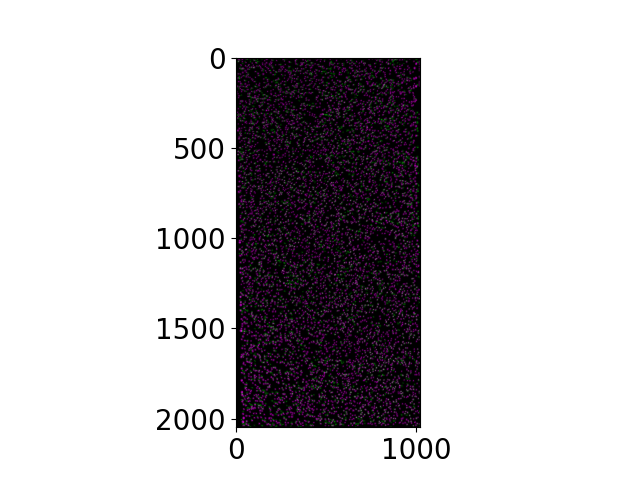

In [28]:
i = 0 #Fluorescence frame (0 = PE-anti-CD9, 1 = PE-anti-biotin)
j = 0 #Position on the chip

k = 2 #Scattering frame
imnorm_fl = normalize_peaks(If[i, j], Lf[i, j])
imnorm_sc = normalize_peaks(Ibg[k, j], L[k, j])
imnorm_fl = np.float32(imnorm_fl)
imnorm_sc = np.float32(imnorm_sc)

tx = -8
ty = -5
tform1 = np.float32([[1,0,tx],[0,1,ty]])
tform_matrices[i, j, 0] = tform1

sz = imnorm_fl.shape
imnorm_fl = cv2.warpAffine(imnorm_fl, tform1, (sz[1], sz[0]), flags=cv2.INTER_LINEAR)

im1 = colorize(imnorm_fl, 'm', 1.0)
im2 = colorize(imnorm_sc, 'g', 1.0)
%matplotlib widget
fig, ax = plt.subplots(1, 1)
ax.imshow(im1+im2)

In [29]:
warp_matrix1 = ECC(imnorm_sc, imnorm_fl, cv2.MOTION_TRANSLATION, 100, 1e-10)
tform_matrices[i, j, 1] = warp_matrix1

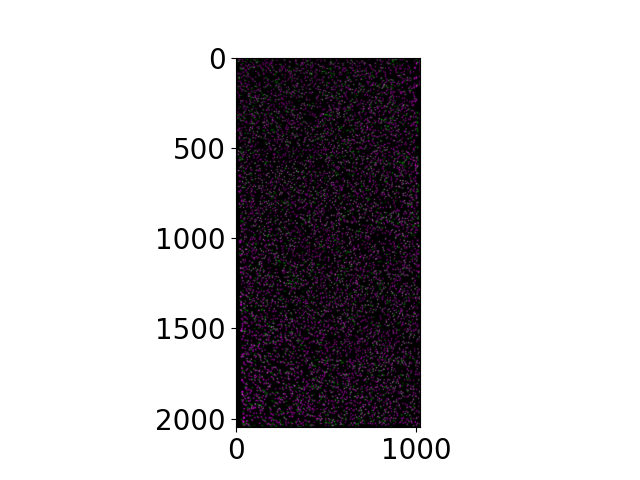

In [32]:
%matplotlib widget
fig, ax = plt.subplots(1, 1)
sz = imnorm_sc.shape 
imnorm_fl_trans = cv2.warpAffine(imnorm_fl, warp_matrix1, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

im1 = colorize(imnorm_fl_trans, 'm', 1.0)
im2 = colorize(imnorm_sc, 'g', 1.0)
plt.imshow(im1+im2)

In [33]:
# Run the ECC algorithm. The results are stored in warp_matrix.
warp_matrix2 = ECC(imnorm_sc, imnorm_fl_trans, cv2.MOTION_AFFINE, 100, 1e-10)
tform_matrices[i, j, 2] = warp_matrix2

58558.89


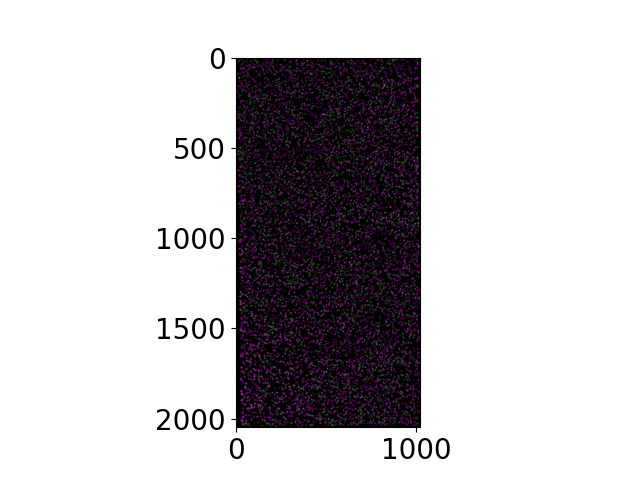

In [34]:
%matplotlib widget
fig, ax = plt.subplots(1, 1)
# Use warpAffine for Translation, Euclidean and Affine
imnorm_fl_a = cv2.warpAffine(imnorm_fl_trans, warp_matrix2, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
print(np.nanmean(imnorm_sc*imnorm_fl_trans))

im1 = colorize(imnorm_fl_a, 'm', 1.0)
im2 = colorize(imnorm_sc, 'g', 1.0)
plt.imshow(im1+im2)

In [35]:
#np.save(f'Results/tform_matrices', tform_matrices)
tform_matrices = np.load(f'Results/tform_matrices.npy', allow_pickle=True)

Align all fluorescence frames based on the transformation matrix tform_matrices

In [36]:
Lfa = np.zeros((If.shape[0], If.shape[1], 2048, 1024)).astype(int) #Aligned fluorescent particle labels
Lfabg = Lf.copy()
sz = Lfa[0, 0].shape

t = [0.5, 0.5, 0.5]
If_affine = If.copy()
Ifbg_affine = Ifbg.copy()
for i in range(If.shape[0]):
    for j in range(If.shape[1]):
        If_affine[i, j] = cv2.warpAffine(If[i, j].astype(float), tform_matrices[i, j, 0], (sz[1], sz[0]), flags=cv2.INTER_LINEAR).astype(np.uint16)
        If_affine[i, j] = cv2.warpAffine(If_affine[i, j].astype(float), tform_matrices[i, j, 1], (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP).astype(np.uint16)
        If_affine[i, j] = cv2.warpAffine(If_affine[i, j].astype(float), tform_matrices[i, j, 2], (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP).astype(np.uint16)

        Ifbg_affine[i, j] = cv2.warpAffine(Ifbg[i, j].astype(float), tform_matrices[i, j, 0], (sz[1], sz[0]), flags=cv2.INTER_LINEAR)
        Ifbg_affine[i, j] = cv2.warpAffine(Ifbg_affine[i, j].astype(float), tform_matrices[i, j, 1], (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        Ifbg_affine[i, j] = cv2.warpAffine(Ifbg_affine[i, j].astype(float), tform_matrices[i, j, 2], (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        p, lbg, sbg = locate_particles(Ifbg_affine[i, j], size_side = 12, dilate_r = 6, thres_max = t[i], thickening = 8)
        Lfa[i, j], Lfabg[i, j] = label_particles(lbg, sbg, disk_sizes = [2, 1, 7, 3], thickening = 2)    

Calculate fluorescence intensities

In [38]:
Ints_f = np.empty((L.shape[0], L.shape[1]), dtype='object')
coords_f = np.empty((L.shape[0], L.shape[1]), dtype='object')
saturated_f = np.empty((L.shape[0], L.shape[1]), dtype='object')

for i in range(Lfa.shape[0]):
    for j in range(Lfa.shape[1]):
        Ints_f[i, j], coords_f[i, j], saturated_f[i, j] = calculate_intensities(If_affine[i, j], Lfa[i, j], Lfabg[i, j])

Initialize dataframes for antibody binding data

In [39]:
columns = ['Particle', 'Position', 'Coordinates', 'Saturated', 'Intensity']
convert_dict = {columns[0]: int, columns[1]: int, columns[2]: object, columns[3]: int, columns[4]: float}

def init_dataframe_fl(i, columns, coords, saturated, Ints, convert_dict):
    df = pd.DataFrame(columns=columns)

    for j in range(Ints.shape[1]):

        data_to_add = pd.DataFrame(
            {
            'Particle': np.arange(1, len(Ints[i, j])+1),
            'Position': j,
            'Coordinates': coords[i, j],
            'Saturated': saturated[i, j],
            'Intensity': Ints[i, j],
            })
        df = pd.concat([df, data_to_add], ignore_index=True)
    return df.astype(convert_dict)

df_ab1 = init_dataframe_fl(0, columns, coords_f, saturated_f, Ints_f, convert_dict)
df_ab2 = init_dataframe_fl(1, columns, coords_f, saturated_f, Ints_f, convert_dict)
df_ab3 = init_dataframe_fl(2, columns, coords_f, saturated_f, Ints_f, convert_dict)

Calculate distances between particles detected in scattering and fluorescence

In [40]:
pnames = ['CD9', 'CD41', 'Biotin']
initialize_pnames(pnames, df_ev)
for index, particle in df_ev.iterrows():
    j = particle['Position']

    subdata = df_ab1.query('Position == @j')
    update_particle_info(df_ev, index, subdata, particle, pnames[0])

    subdata = df_ab3.query('Position == @j')
    update_particle_info(df_ev, index, subdata, particle, pnames[1])

    subdata = df_ab2.query('Position == @j')
    update_particle_info(df_ev, index, subdata, particle, pnames[2])
    print(f'Analyzing particle #{index}')

Analyzing particle #0
Analyzing particle #1
Analyzing particle #2
Analyzing particle #3
Analyzing particle #4
Analyzing particle #5
Analyzing particle #6
Analyzing particle #7
Analyzing particle #8
Analyzing particle #9
Analyzing particle #10
Analyzing particle #11
Analyzing particle #12
Analyzing particle #13
Analyzing particle #14
Analyzing particle #15
Analyzing particle #16
Analyzing particle #17
Analyzing particle #18
Analyzing particle #19
Analyzing particle #20
Analyzing particle #21
Analyzing particle #22
Analyzing particle #23
Analyzing particle #24
Analyzing particle #25
Analyzing particle #26
Analyzing particle #27
Analyzing particle #28
Analyzing particle #29
Analyzing particle #30
Analyzing particle #31
Analyzing particle #32
Analyzing particle #33
Analyzing particle #34
Analyzing particle #35
Analyzing particle #36
Analyzing particle #37
Analyzing particle #38
Analyzing particle #39
Analyzing particle #40
Analyzing particle #41
Analyzing particle #42
Analyzing particle #4

In [41]:
pnames = ['Biotin']

initialize_pnames(pnames, df_ves)
for index, particle in df_ves.iterrows():
    j = particle['Position']
   
    subdata = df_ab2.query('Position == @j')
    update_particle_info(df_ves, index, subdata, particle, pnames[0])
    print(f'Analyzing particle #{index}')

Analyzing particle #0
Analyzing particle #1
Analyzing particle #2
Analyzing particle #3
Analyzing particle #4
Analyzing particle #5
Analyzing particle #6
Analyzing particle #7
Analyzing particle #8
Analyzing particle #9
Analyzing particle #10
Analyzing particle #11
Analyzing particle #12
Analyzing particle #13
Analyzing particle #14
Analyzing particle #15
Analyzing particle #16
Analyzing particle #17
Analyzing particle #18
Analyzing particle #19
Analyzing particle #20
Analyzing particle #21
Analyzing particle #22
Analyzing particle #23
Analyzing particle #24
Analyzing particle #25
Analyzing particle #26
Analyzing particle #27
Analyzing particle #28
Analyzing particle #29
Analyzing particle #30
Analyzing particle #31
Analyzing particle #32
Analyzing particle #33
Analyzing particle #34
Analyzing particle #35
Analyzing particle #36
Analyzing particle #37
Analyzing particle #38
Analyzing particle #39
Analyzing particle #40
Analyzing particle #41
Analyzing particle #42
Analyzing particle #4

In [66]:
limit = 3
subset = df_ev.query('Overlap > 10 and Saturated == 0')
N = len(subset)
N1 = len(subset.query('`CD9 Distance` < @limit and `CD41 Distance` < @limit'))
N2 = len(subset.query('`CD9 Distance` < @limit'))
N3 = len(subset.query('`CD41 Distance` < @limit'))
print(f'Double positive (CD9/CD41): {N1/N}')
print(f'Single positive (CD9): {N2/N}')
print(f'Single positive (CD41): {N3/N}')

Double positive (CD9/CD41): 0.4143586985748857
Single positive (CD9): 0.48198440440978757
Single positive (CD41): 0.506722237160527


Align time-resolved fluorescence data

In [42]:
file = 'AB_binding1_fl'
path = f'{base_path}/{file}.tif'
frames_fl = tf.imread(path)

p, lbg, sbg = locate_particles(reference_removal_fluor(frames_fl[0], 20, 5), size_side = 12, dilate_r = 6, thres_max = 0.5, thickening = 8)
Lf_ab1, Lfbg_ab1 = label_particles(lbg, sbg, disk_sizes = [2, 1, 7, 3], thickening = 2)   

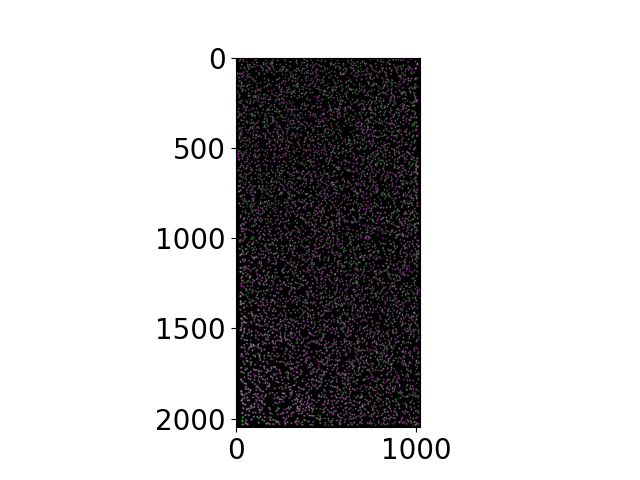

In [44]:
j = 0
k = 2
imnorm_fl = normalize_peaks(frames_fl[0], Lf_ab1)
imnorm_sc = normalize_peaks(Ifbg_affine[0, j], Lfa[0, j])
imnorm_fl = np.float32(imnorm_fl)
imnorm_sc = np.float32(imnorm_sc)

tx = 0
ty = 0
tform1 = np.float32([[1,0,tx],[0,1,ty]])
tform_matrices = np.empty((2, 3), dtype=object)
i = 0
tform_matrices[i, 0] = tform1
warp_mode = cv2.MOTION_TRANSLATION
sz = imnorm_sc.shape
imnorm_fl = cv2.warpAffine(imnorm_fl, tform1, (sz[1], sz[0]), flags=cv2.INTER_LINEAR)

warp_matrix1 = ECC(imnorm_sc, imnorm_fl, cv2.MOTION_TRANSLATION, 100, 1e-10)
tform_matrices[i, 1] = warp_matrix1
imnorm_fl_trans = cv2.warpAffine(imnorm_fl, warp_matrix1, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

warp_matrix2 = ECC(imnorm_sc, imnorm_fl_trans, cv2.MOTION_AFFINE, 100, 1e-10)
tform_matrices[i, 2] = warp_matrix2
imnorm_fl_a = cv2.warpAffine(imnorm_fl_trans, warp_matrix2, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

%matplotlib widget

fig, ax = plt.subplots(1, 1)
im1 = colorize(imnorm_fl_a, 'm', 1.0)
im2 = colorize(imnorm_sc, 'g', 1.0)
plt.imshow(im1+im2)


In [45]:
file = 'AB_binding2_fl'
path = f'{base_path}/{file}.tif'
frames_fl = tf.imread(path)

p, lbg, sbg = locate_particles(reference_removal_fluor(frames_fl[0], 20, 5), size_side = 12, dilate_r = 6, thres_max = 0.5, thickening = 8)
Lf_ab2, Lfbg_ab2 = label_particles(lbg, sbg, disk_sizes = [2, 1, 7, 3], thickening = 2)     

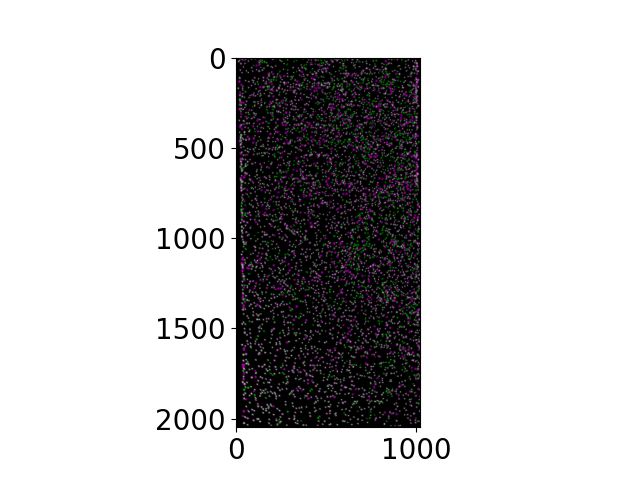

In [47]:
j = 0
k = 1
imnorm_fl = normalize_peaks(frames_fl[0], Lf_ab2)
#imnorm_sc = normalize_peaks(Ibg[k, j], L[k, j])
imnorm_sc = normalize_peaks(Ifbg_affine[1, j], Lfa[1, j])
imnorm_fl = np.float32(imnorm_fl)
imnorm_sc = np.float32(imnorm_sc)

tx = 0
ty = 0
tform1 = np.float32([[1,0,tx],[0,1,ty]])
i = 1
tform_matrices[i, 0] = tform1
warp_mode = cv2.MOTION_TRANSLATION
sz = imnorm_sc.shape
imnorm_fl = cv2.warpAffine(imnorm_fl, tform1, (sz[1], sz[0]), flags=cv2.INTER_LINEAR)

warp_matrix1 = ECC(imnorm_sc, imnorm_fl, cv2.MOTION_TRANSLATION, 100, 1e-10)
tform_matrices[i, 1] = warp_matrix1
imnorm_fl_trans = cv2.warpAffine(imnorm_fl, warp_matrix1, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

warp_matrix2 = ECC(imnorm_sc, imnorm_fl_trans, cv2.MOTION_AFFINE, 100, 1e-10)
tform_matrices[i, 2] = warp_matrix2
imnorm_fl_a = cv2.warpAffine(imnorm_fl_trans, warp_matrix2, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

%matplotlib widget

fig, ax = plt.subplots(1, 1)
im1 = colorize(imnorm_fl_a, 'm', 1.0)
im2 = colorize(imnorm_sc, 'g', 1.0)
plt.imshow(im1+im2)

In [48]:
#np.save(f'Results/tform_matrices_kinetics', tform_matrices)
tform_matrices = np.load(f'Results/tform_matrices_kinetics.npy', allow_pickle=True)

Analyze antibody binding kinetics

In [49]:
file = 'AB_binding1_aligned_sc'
path = f'{base_path}/{file}.tif'
frames_sc = tf.imread(path)[1:]

file = 'AB_binding1_fl'
path = f'{base_path}/{file}.tif'
frames_fl = tf.imread(path)[1:]
k = 0

Ints_s1 = np.empty((frames_sc.shape[0], Ints[2, 0].shape[0]))
Ints_sagg = np.empty((frames_sc.shape[0], Ints[3, 0].shape[0]))
Ints_f1 = np.empty((frames_fl.shape[0], Ints_f[0, 0].shape[0]))
saturated = np.empty((frames_sc.shape[0], Ints[2, 0].shape[0])).astype(int)
saturated_fl = np.empty((frames_fl.shape[0], Ints_f[0, 0].shape[0])).astype(int)
for i, frame in enumerate(frames_fl):
    If_affine = cv2.warpAffine(frame, tform_matrices[k, 0], (sz[1], sz[0]), flags=cv2.INTER_LINEAR)
    If_affine = cv2.warpAffine(If_affine, tform_matrices[k, 1], (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    If_affine = cv2.warpAffine(If_affine, tform_matrices[k, 2], (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    Ints_f1[i, :], _, saturated_fl[i, :] = calculate_intensities(If_affine, Lfa[0, 0], Lfabg[0, 0])
    Ints_s1[i, :], _, saturated[i, :] = calculate_intensities(frames_sc[i], L[2, 0], Lbg[2, 0])
    Ints_sagg[i, :], _, _ = calculate_intensities(frames_sc[i], L[3, 0], Lbg[3, 0])

Div_time_f = np.empty(Ints_f1.shape[1])
for i in range(Ints_f1.shape[1]):
    y1 = Ints_f1[1:, i]
    y0 = Ints_f1[0:-1, i]
    Div_time_f[i] = np.nanargmax(np.abs(y1) / np.abs(y0))

In [50]:
def rate_equation(t, A0, A, tau):
    return A0 + A*(1-np.exp(-t/tau))
def rate_equation_delay(t, A0, A, t0, tau):
    idx = np.nanargmin(np.abs(t-t0))
    y = np.zeros(len(t))
    y[:idx] = A0
    y[idx:] = A0 + A*(1-np.exp(-(t[idx:]-t0)/tau))
    return y

res = 0.5 
x = np.arange(0, res*frames_fl.shape[0], res)

delay_f = np.empty(Ints_f1.shape[1])
rates_f = np.empty(Ints_f1.shape[1])
scat_increase = np.empty(Ints_s1.shape[1])
scat_sagg_increase = np.empty(Ints_sagg.shape[1])
fluor_increase = np.empty(Ints_f1.shape[1])
errors = np.empty(Ints_f1.shape[1])

for i in range(Ints_f1.shape[1]):
    y = Ints_f1[:, i]
    try:
        results, pcov = curve_fit(lambda t, A0, A, t0, tau: rate_equation_delay(t, A0, A, t0, tau), x, y,\
                        p0 = [y[0], np.nanmax(y), Div_time_f[i]*res, 1] ) 
        rates_f[i] = results[3]
        delay_f[i] = results[2]
        fluor_increase[i] = results[1]
        errors[i] = np.sqrt(np.diag(pcov))[3]
    except (RuntimeError, TypeError) as e:
        rates_f[i] = np.nan

offset = 4
x = x[:-offset]
rates_s = np.empty(Ints_s1.shape[1])
for i in range(Ints_s1.shape[1]):
    y = Ints_s1[offset:, i]
    try:
        results, _ = curve_fit(lambda t, A0, A, tau: rate_equation(t, A0, A, tau), x, y,\
                        p0 = [y[0], np.nanmax(y), 1] ) 
        rates_s[i] = results[2]
        scat_increase[i] = results[1] / results[0]
    except (RuntimeError, TypeError) as e:
        rates_s[i] = np.nan

C:\Users\ppark\AppData\Local\Temp\ipykernel_10248\2379389447.py:7: RuntimeWarning: overflow encountered in exp
  y[idx:] = A0 + A*(1-np.exp(-(t[idx:]-t0)/tau))
c:\Users\ppark\anaconda3\envs\ev_wgsm\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\ppark\AppData\Local\Temp\ipykernel_10248\2379389447.py:7: RuntimeWarning: overflow encountered in multiply
  y[idx:] = A0 + A*(1-np.exp(-(t[idx:]-t0)/tau))
C:\Users\ppark\AppData\Local\Temp\ipykernel_10248\2379389447.py:2: RuntimeWarning: overflow encountered in exp
  return A0 + A*(1-np.exp(-t/tau))
C:\Users\ppark\AppData\Local\Temp\ipykernel_10248\2379389447.py:2: RuntimeWarning: overflow encountered in multiply
  return A0 + A*(1-np.exp(-t/tau))


In [51]:
def update_time_series(df, df_ab, pname, Ints_s, Ints_f, rates_s, rates_f, scat_increase, fluor_increase, saturated, saturated_fl):
    df['Fluorescence time series'] = np.empty((len(df)), dtype=object)
    df['Scattering time series'] = np.empty((len(df)), dtype=object)
    df_ab['Fluorescence time series'] = np.empty((len(df_ab)), dtype=object)

    idx = df.query('Position == 0').index.values
    df.loc[idx, 'Scattering rate'] = rates_s
    df.loc[idx, 'Scattering increase'] = scat_increase
    if saturated is not None:
        df.loc[idx, 'Saturated rate'] = np.nanmax(saturated, axis=0)

    idx = df_ab.query('Position == 0').index.values
    df_ab.loc[idx, 'Fluorescence rate'] = rates_f
    df_ab.loc[idx, 'Fluorescence rate err'] = errors
    df_ab.loc[idx, 'Fluorescence increase'] = fluor_increase
    if saturated_fl is not None:
        df_ab.loc[idx, 'Saturated rate'] = np.nanmax(saturated_fl, axis=0)
    for index, particle in df_ab.iterrows():
        if particle['Position'] == 0:
            df_ab.at[index, 'Fluorescence time series'] = Ints_f[:, index]

    for index, particle in df.iterrows():
        if particle['Position'] == 0:
            idx = particle['Particle'] - 1
            df.at[index, 'Scattering time series'] = Ints_s[:, idx]
            idx = particle[f'{pname} Particle'] - 1
            df.at[index, 'Fluorescence time series'] = Ints_f[:, idx]
            if saturated_fl is not None:
                df.at[index, 'Saturated fl rate'] = np.nanmax(saturated_fl[:, idx])
            if pd.notnull(idx):
                df.at[index, 'Fluorescence rate'] = rates_f[int(idx)]
                df.at[index, 'Fluorescence rate err'] = errors[int(idx)]
                df.at[index, 'Fluorescence increase'] = fluor_increase[int(idx)]

update_time_series(df_ev, df_ab1, 'CD9', Ints_s1, Ints_f1, rates_s, rates_f, scat_increase, fluor_increase, saturated, saturated_fl)

In [52]:
file = 'AB_binding2_aligned_sc'
path = f'{base_path}/{file}.tif'
frames_sc = tf.imread(path)[1:]

file = 'AB_binding2_fl'
path = f'{base_path}/{file}.tif'
frames_fl = tf.imread(path)[1:]
k = 1

Ints_s2 = np.empty((frames_sc.shape[0], Ints[1, 0].shape[0]))
Ints_f2 = np.empty((frames_fl.shape[0], Ints_f[1, 0].shape[0]))
saturated = np.empty((frames_sc.shape[0], Ints[1, 0].shape[0])).astype(int)
saturated_fl = np.empty((frames_fl.shape[0], Ints_f[1, 0].shape[0])).astype(int)
for i, frame in enumerate(frames_fl):
    If_affine = cv2.warpAffine(frame, tform_matrices[k, 0], (sz[1], sz[0]), flags=cv2.INTER_LINEAR)
    If_affine = cv2.warpAffine(If_affine, tform_matrices[k, 1], (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    If_affine = cv2.warpAffine(If_affine, tform_matrices[k, 2], (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    Ints_f2[i, :], _, saturated_fl[i, :] = calculate_intensities(If_affine, Lfa[1, 0], Lfabg[1, 0])
    Ints_s2[i, :], _, saturated[i, :] = calculate_intensities(frames_sc[i], L[1, 0], Lbg[1, 0])

Div_time_f = np.empty(Ints_f2.shape[1])
for i in range(Ints_f2.shape[1]):
    y1 = Ints_f2[1:, i]
    y0 = Ints_f2[0:-1, i]
    Div_time_f[i] = np.nanargmax(np.abs(y1) / np.abs(y0))

In [53]:
res = 0.5 
x = np.arange(0, res*frames_fl.shape[0], res)

delay_f = np.empty(Ints_f2.shape[1])
rates_f = np.empty(Ints_f2.shape[1])
scat_increase = np.empty(Ints_s2.shape[1])
scat_sagg_increase = np.empty(Ints_sagg.shape[1])
fluor_increase = np.empty(Ints_f2.shape[1])
errors = np.empty(Ints_f2.shape[1])

for i in range(Ints_f2.shape[1]):
    y = Ints_f2[:, i]
    try:
        results, pcov = curve_fit(lambda t, A0, A, t0, tau: rate_equation_delay(t, A0, A, t0, tau), x, y,\
                        p0 = [y[0], np.nanmax(y), Div_time_f[i]*res, 1] ) 
        rates_f[i] = results[3]
        delay_f[i] = results[2]
        fluor_increase[i] = results[1]
        errors[i] = np.sqrt(np.diag(pcov))[3]
    except (RuntimeError, TypeError) as e:
        rates_f[i] = np.nan

offset = 3
x = x[:-offset]
rates_s = np.empty(Ints_s2.shape[1])
for i in range(Ints_s2.shape[1]):
    y = Ints_s2[offset:, i]
    try:
        results, _ = curve_fit(lambda t, A0, A, tau: rate_equation(t, A0, A, tau), x, y,\
                        p0 = [y[0], np.nanmax(y), 1] ) 
        rates_s[i] = results[2]
        scat_increase[i] = results[1] / results[0]
    except (RuntimeError, TypeError) as e:
        rates_s[i] = np.nan

c:\Users\ppark\anaconda3\envs\ev_wgsm\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\ppark\AppData\Local\Temp\ipykernel_10248\2379389447.py:7: RuntimeWarning: overflow encountered in exp
  y[idx:] = A0 + A*(1-np.exp(-(t[idx:]-t0)/tau))
C:\Users\ppark\AppData\Local\Temp\ipykernel_10248\2379389447.py:7: RuntimeWarning: overflow encountered in multiply
  y[idx:] = A0 + A*(1-np.exp(-(t[idx:]-t0)/tau))
C:\Users\ppark\AppData\Local\Temp\ipykernel_10248\2379389447.py:2: RuntimeWarning: overflow encountered in exp
  return A0 + A*(1-np.exp(-t/tau))
C:\Users\ppark\AppData\Local\Temp\ipykernel_10248\2379389447.py:2: RuntimeWarning: overflow encountered in multiply
  return A0 + A*(1-np.exp(-t/tau))


In [54]:
update_time_series(df_ves, df_ab2, 'Biotin', Ints_s2, Ints_f2, rates_s, rates_f, scat_increase, fluor_increase, saturated, saturated_fl)

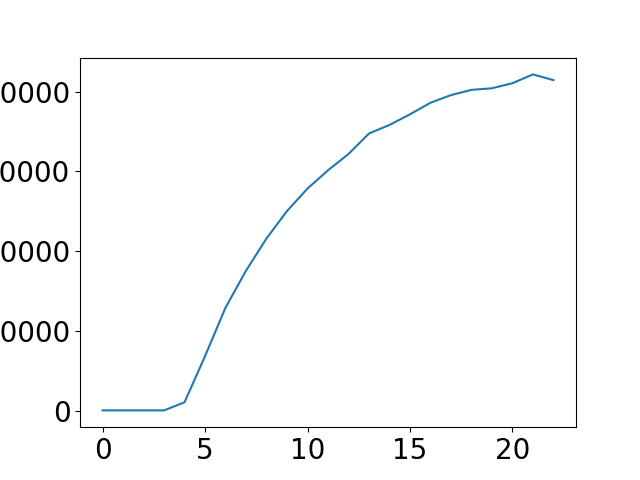

In [78]:
%matplotlib widget
fig, ax = plt.subplots(1, 1)
limit = 3
y = np.vstack(df_ev.query('`CD9 Distance` < @limit and Position == 0')['Fluorescence time series'])
plt.plot(np.nanmedian(y, axis=0))

Prepare data for analysis based on medium exchanges

In [79]:
calculate_medium_exchange(0, df_snp, Ii, Ig, L, Lbg)
snp_medians = calculate_ref_medians(df_snp, 2, 8)
calculate_medium_exchange(1, df_ves, Ii, Ig, L, Lbg)
calculate_medium_exchange(2, df_ev, Ii, Ig, L, Lbg)

In [80]:
# Iodixanol refractive indices
n_m1 = np.array([1.3350, 1.3426, 1.3502, 1.3579, 1.3655, 1.3731, 1.3807, 1.3883])

# Glycerol
n_m2 = n_m1.copy()

I_ref = IntensitySphere2(n_m1, n_m2, 50, 0, 1.43, 1.43, 488)

In [81]:
snp_medians = calculate_ref_medians(df_snp, 2, 8)
I_ref = IntensitySphere2(n_m1, n_m2, 50, 0, 1.43, 1.43, 488)

normalize_media_exchange(df_ev, snp_medians, I_ref)
normalize_media_exchange(df_ves, snp_medians, I_ref)

[1.24579625 1.12762183 1.06380517 1.03854667 1.17175393 1.15870939
 1.12943038 1.24269516]


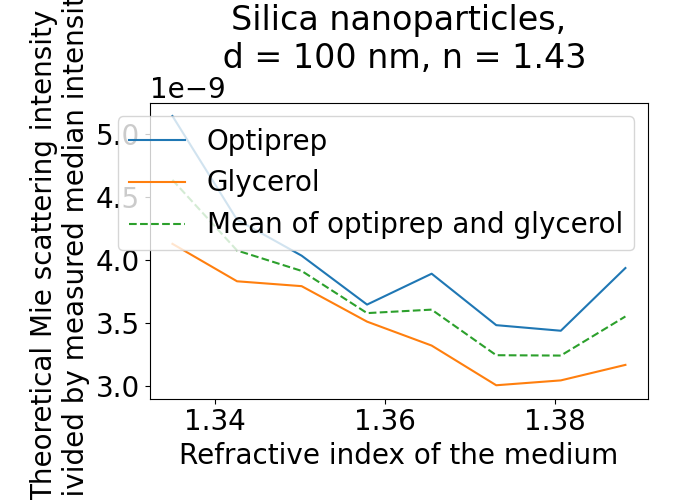

In [82]:
%matplotlib widget

snp_medians = calculate_ref_medians(df_snp.query('Overlap > 10 and Saturated == 0'), 2, 8)

medians_mean = np.zeros((3, 2, 8))
for j in range(3):
    corr = np.mean([snp_medians[j, 0], snp_medians[j, 1]], axis=0)
    medians_mean[j, 0, :] = corr
    medians_mean[j, 1, :] = corr

j = 2
corr = np.mean([I_ref[0:8]/snp_medians[j, 0], I_ref[8:]/snp_medians[j, 1]], axis=0)

plt.figure(figsize=(7,5))
plt.plot(n_m1, I_ref[0:8]/snp_medians[j, 0], label = 'Optiprep')
plt.plot(n_m2, I_ref[8:]/snp_medians[j, 1], label = 'Glycerol')
plt.plot(n_m1, corr, '--', label = 'Mean of optiprep and glycerol')
print((I_ref[0:8]/snp_medians[j, 0]) / (I_ref[8:]/snp_medians[j, 1]))

plt.xlabel('Refractive index of the medium')
plt.ylabel('Theoretical Mie scattering intensity \n divided by measured median intensity')
plt.title('Silica nanoparticles,\n d = 100 nm, n = 1.43')
plt.legend()
plt.tight_layout()

[40.04083406  0.62266345  1.41893789]
[0.18812596 0.22114693 0.00189027]


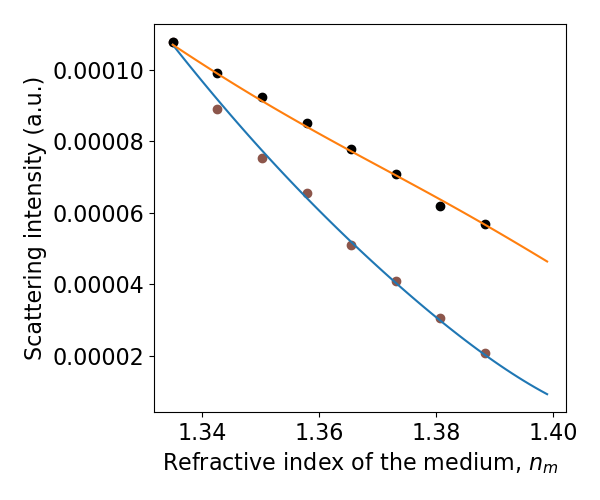

In [87]:
%matplotlib widget
mpl.rc('figure',  figsize=(6, 5))
mpl.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 1)
x = np.concatenate((n_m1, n_m2))

medians = calculate_medians(df_ev.query('Overlap > 10 and Saturated == 0'), 2, 8)
y1 = medians[0, :]
y2 = medians[1, :]
corr1 = (np.nanmean([y1[0], y2[0]])/y1[0])
corr2 = (np.nanmean([y1[0], y2[0]])/y2[0])

y1 = corr1*y1
y2 = corr2*y2

plt.plot(n_m1, y1, 'o', color = 'C5')
plt.plot(n_m2, y2, 'o', color = 'k')

xres = np.arange(1.335, 1.4, 0.001)

y = np.concatenate((y1, y2))
t = 7.3
n_s = 1.48
res, _ = curve_fit(lambda n_m, r, fp, n1: IntensityVolumeSphere(n_m1, n_m2, r, fp, n1, 488), x, y,\
                    p0 = [50, 0.0, 1.45] ) 
    
yres = IntensityVolumeSphere(xres, xres, res[0], res[1], res[2], 488)
#Radius, biomolecular volume, effective RI
print(res)
# Errors
print(np.sqrt(np.diag(pcov)))

plt.plot(xres, yres[0:len(yres)//2], color='C0')
plt.plot(xres, yres[len(yres)//2:], color='C1')

plt.ylabel('Scattering intensity (a.u.)')
plt.xlabel('Refractive index of the medium, $n_m$')

plt.tight_layout()

Scattering normalized to silica particles before and after antibody binding

In [88]:
bins = np.arange(-1, 5, 0.1)

def calculate_scattering_fractions(df, df_ref, Ibefore, Iafter):
    df['Scattering increase all'] = np.nan
    N_pos = np.nanmax(df['Position'])+1
    for i in range(N_pos):
        subdata_snp = df_ref.query('Position == @i & Saturated == 0 & Overlap > 10')
        idx = df.query('Position == @i').index.values
        Inorm = df.loc[idx, f'{Iafter}'] / np.nanmedian(subdata_snp[f'{Iafter}'])
        Inorm0 = df.loc[idx, f'{Ibefore}'] / np.nanmedian(subdata_snp[f'{Ibefore}'])
        df.loc[idx, 'Scattering increase all'] = (Inorm - Inorm0) / Inorm0

calculate_scattering_fractions(df_ev, df_snp, 'Intensity2', 'Intensity3')

%matplotlib widget
plt.hist(df_ev['Scattering increase all'], bins=bins, alpha=0.2)
print(np.nanmedian(df_ev['Scattering increase all']))

calculate_scattering_fractions(df_ev, df_snp, 'Intensity1', 'Intensity2')

plt.hist(df_ev['Scattering increase all'], bins=bins, alpha=0.2)
print(np.nanmedian(df_ev['Scattering increase all']))

plt.xlim(-1, 5)

plt.hist(df_ev['Scattering increase'], bins = bins, alpha=0.2)
print(np.nanmedian(df_ev['Scattering increase']))


-0.054423461759530126
0.17834537744337423
0.10684834727261627


In [89]:
bins = np.arange(-1, 5, 0.1)

calculate_scattering_fractions(df_ves, df_snp, 'Intensity1', 'Intensity2')

%matplotlib widget
plt.hist(df_ves['Scattering increase all'], bins=bins, alpha=0.2)
print(np.nanmedian(df_ves['Scattering increase all']))

calculate_scattering_fractions(df_ves, df_snp, 'Intensity2', 'Intensity3')

plt.hist(df_ves['Scattering increase all'], bins=bins, alpha=0.2)
print(np.nanmedian(df_ves['Scattering increase all']))

plt.xlim(-1, 5)

plt.hist(df_ves['Scattering increase'], bins = bins, alpha=0.2)
print(np.nanmedian(df_ves['Scattering increase']))


0.033677797402154167
0.07560774024301985
0.18735477237903037


In [90]:
bins = np.arange(-1, 5, 0.1)

def calculate_scattering_fractions2(df, df_ref, Ibefore, Iafter):
    df['Scattering increase all Biotin'] = np.nan
    N_pos = np.nanmax(df['Position'])+1
    for i in range(N_pos):
        subdata_snp = df_ref.query('Position == @i & Saturated == 0 & Overlap > 10')
        idx = df.query('Position == @i').index.values
        Inorm = df.loc[idx, f'{Iafter}'] / np.nanmedian(subdata_snp[f'{Iafter}'])
        Inorm0 = df.loc[idx, f'{Ibefore}'] / np.nanmedian(subdata_snp[f'{Ibefore}'])
        df.loc[idx, 'Scattering increase all Biotin'] = (Inorm - Inorm0) / Inorm0

calculate_scattering_fractions2(df_ev, df_snp, 'Intensity2', 'Intensity3')

%matplotlib widget
plt.hist(df_ev['Scattering increase all'], bins=bins, alpha=0.2)
print(np.nanmedian(df_ev['Scattering increase all']))

plt.hist(df_ev['Scattering increase all Biotin'], bins=bins, alpha=0.2)
print(np.nanmedian(df_ev['Scattering increase all Biotin']))

0.17834537744337423
-0.054423461759530126


Analyze synthetic vesicles based on core-shell Mie scattering model (core RI $n_c$ = 1.335)

In [91]:
x = np.concatenate((n_m1, n_m2))
results = np.empty((len(df_ves), 8))*np.nan
mass = np.empty(len(df_ves))*np.nan

medians = calculate_medians(df_ves.query('Overlap > 10 and Saturated == 0'), 2, 8)
y1 = medians[0, :]
y2 = medians[1, :]
corr1 = (np.nanmean([y1[0], y2[0]])/y1[0])
corr2 = (np.nanmean([y1[0], y2[0]])/y2[0])

for index, particle in df_ves.iterrows():
    y = np.concatenate((df_ves.at[index, 'Iodixanol series normalized']*corr1, df_ves.at[index, 'Glycerol series normalized']*corr2))
    
    try:
        #Core-shell
        res, pcov = curve_fit(lambda n_m, r, t, n_s: IntensityVesicle(n_m1, n_m2, r, t, n_s, 488), x, y,\
                    p0 = [50, 5, 1.45]) 
        yfit = IntensityVesicle(n_m1, n_m2, res[0], res[1], res[2], 488)
        #Calculate R-squared
        r_squared = 1 - (np.nansum((y - yfit)**2) / np.nansum((y - np.nanmean(y))**2))

        results[index, :3] = res
        results[index, 3] = r_squared
        results[index, 4] = calculate_mape(y, yfit)
        results[index, 5:8] = np.sqrt(np.diag(pcov))
        mass[index] = 100*res[1]*(res[2]-1.335)/0.16

        if (index % 10) == 0:
            print(f'Particle #{index} out of {len(df_ves)} is analyzed')
            print(np.nanmedian(results, axis=0))
            print(np.nanmedian(mass))
    except (RuntimeError, TypeError) as e:
        continue

Particle #0 out of 5570 is analyzed
[ 2.15670617e+00  2.01715643e+00  1.38549637e+00 -4.15185502e+00
  1.00000002e+00  3.67580903e+07  7.25029600e+09  2.02083096e+06]
63.661925167019675
Particle #10 out of 5570 is analyzed
[5.23731076e+01 1.05275510e+01 1.43349949e+00 5.87500128e-01
 6.70681505e-01 5.10893986e+00 6.04707368e+00 3.41577764e-02]
675.8436582246121


c:\Users\ppark\anaconda3\envs\ev_wgsm\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Particle #20 out of 5570 is analyzed
[4.86013948e+01 1.03767132e+01 1.42839050e+00 6.11802150e-01
 1.00000001e+00 5.11807840e+00 5.50096462e+00 3.01590912e-02]
789.6978390673473
Particle #30 out of 5570 is analyzed
[5.12755306e+01 1.16673147e+01 1.43161356e+00 6.58027225e-01
 5.99042203e-01 5.10893986e+00 5.55882496e+00 2.61180252e-02]
793.264841436924
Particle #40 out of 5570 is analyzed
[5.11364147e+01 1.11890354e+01 1.42972137e+00 6.58027225e-01
 6.10923291e-01 5.09361983e+00 5.25315717e+00 2.71175987e-02]
764.2408192105033
Particle #50 out of 5570 is analyzed
[5.00744215e+01 9.49171563e+00 1.43294442e+00 5.96052292e-01
 6.70730538e-01 5.13668055e+00 4.92390443e+00 2.96977557e-02]
741.9310127617146
Particle #60 out of 5570 is analyzed
[5.05683621e+01 1.01730714e+01 1.43105223e+00 6.50314766e-01
 7.22618084e-01 5.08743834e+00 4.84245914e+00 2.89115901e-02]
754.8142964058267
Particle #70 out of 5570 is analyzed
[5.00744215e+01 1.02748923e+01 1.42976789e+00 6.06424618e-01
 7.81639814e-

KeyboardInterrupt: 

In [9]:
fnames = ['Radius Vt', 'Thickness Vt', 'Shell RI Vt', 'R-squared Vt', 'MAPE Vt', 'Radius Vt err', 'Thickness Vt err', 'Shell RI Vt err']
for i, fname in enumerate(fnames):
    df_ves[fname] = results[:, i]

Analyze synthetic vesicles based on solid sphere Mie scattering model

In [55]:
x = np.concatenate((n_m1, n_m2))
results = np.empty((len(df_ves), 8))*np.nan

medians = calculate_medians(df_ves.query('Overlap > 10 and Saturated == 0'), 2, 8)
y1 = medians[0, :]
y2 = medians[1, :]
corr1 = (np.nanmean([y1[0], y2[0]])/y1[0])
corr2 = (np.nanmean([y1[0], y2[0]])/y2[0])

for index, particle in df_ves.iterrows():
    y = np.concatenate((df_ves.at[index, 'Iodixanol series normalized']*corr1, df_ves.at[index, 'Glycerol series normalized']*corr2))
    
    try:
        #Sphere model
        res, pcov = curve_fit(lambda n_m, r, fp, n1: IntensityVolumeSphere(n_m1, n_m2, r, fp, n1, 488), x, y,\
        p0 = [50, 0.5, 1.4])
        if res[2] < 1.385:
            res, pcov = curve_fit(lambda n_m, r, fp, n1: IntensityVolumeSphere(n_m1, n_m2, r, fp, n1, 488), x, y,\
            p0 = [50, 0.0, 1.38])
        yfit = IntensityVolumeSphere(n_m1, n_m2, res[0], res[1], res[2], 488)
        #Calculate R-squared
        r_squared = 1 - (np.nansum((y - yfit)**2) / np.nansum((y - np.nanmean(y))**2))

        results[index, :3] = res
        results[index, 3] = r_squared
        results[index, 4] = calculate_mape(y, yfit)
        results[index, 5:8] = np.sqrt(np.diag(pcov))

        if (index % 10) == 0:
            print(f'Particle #{index} out of {len(df_ves)} is analyzed')
            print(np.nanmedian(results, axis=0))
    except (RuntimeError, TypeError, ValueError) as e:
        continue


Particle #10 out of 5570 is analyzed
[5.34711016e+01 4.96850715e-01 1.39627769e+00 6.42542002e-01
 3.19076253e-01 4.97180795e+00 1.51922510e-01 1.21476063e-02]
Particle #20 out of 5570 is analyzed
[5.12831004e+01 5.41792770e-01 1.38539108e+00 6.89665405e-01
 5.89918971e-01 5.11453248e+00 1.56513513e-01 1.17390052e-02]
Particle #30 out of 5570 is analyzed
[5.23717200e+01 5.39528849e-01 1.38990916e+00 6.69537644e-01
 5.89918971e-01 5.11453248e+00 1.56513513e-01 1.21661885e-02]
Particle #40 out of 5570 is analyzed
[5.27568949e+01 5.41378743e-01 1.38766550e+00 6.83860599e-01
 5.84821532e-01 4.88643906e+00 1.50351033e-01 1.16961577e-02]
Particle #50 out of 5570 is analyzed
[5.18484437e+01 5.25761838e-01 1.38577479e+00 6.69537644e-01
 5.89918971e-01 4.94156016e+00 1.54125289e-01 1.17390052e-02]
Particle #60 out of 5570 is analyzed
[5.22887339e+01 5.32212671e-01 1.38326511e+00 6.84873359e-01
 5.96209282e-01 4.82581317e+00 1.52181617e-01 1.15953753e-02]
Particle #70 out of 5570 is analyzed
[5.

KeyboardInterrupt: 

In [ ]:
fnames = ['Radius S', 'Volume S', 'RI S', 'R-squared S', 'MAPE S', 'Radius S err', 'Volume S err', 'RI S err']
for i, fname in enumerate(fnames):
    df_ves[fname] = results[:, i]

Analyze EVs based on solid sphere Mie scattering model

In [60]:
x = np.concatenate((n_m1, n_m2))
results = np.empty((len(df_ev), 8))*np.nan

medians = calculate_medians(df_ev.query('Overlap > 10 and Saturated == 0'), 2, 8)
y1 = medians[0, :]
y2 = medians[1, :]
corr1 = (np.nanmean([y1[0], y2[0]])/y1[0])
corr2 = (np.nanmean([y1[0], y2[0]])/y2[0])

for index, particle in df_ev.iterrows():
    y = np.concatenate((df_ev.at[index, 'Iodixanol series normalized']*corr1, df_ev.at[index, 'Glycerol series normalized']*corr2))
    try:
        res, pcov = curve_fit(lambda n_m, r, fp, n1: IntensityVolumeSphere(n_m1, n_m2, r, fp, n1, 488), x, y,\
            p0 = [50, 0.5, 1.4])
        if res[2] < 1.385:
            res, pcov = curve_fit(lambda n_m, r, fp, n1: IntensityVolumeSphere(n_m1, n_m2, r, fp, n1, 488), x, y,\
                p0 = [50, 0.0, 1.38])
            
        yfit = IntensityVolumeSphere(n_m1, n_m2, res[0], res[1], res[2], 488)
        #Calculate R-squared
        r_squared = 1 - (np.nansum((y - yfit)**2) / np.nansum((y - np.nanmean(y))**2))

        results[index, :3] = res
        results[index, 3] = r_squared
        results[index, 4] = calculate_mape(y, yfit)
        results[index, 5:8] = np.sqrt(np.diag(pcov))

        if (index % 10) == 0:
            print(f'Particle #{index} out of {len(df_ev)} is analyzed')
            print(np.nanmedian(results, axis=0))
    except (RuntimeError, TypeError, ValueError) as e:
        continue

Particle #0 out of 11470 is analyzed
[4.60013202e+01 3.45901054e-01 1.37373751e+00 5.35878594e-01
 9.20148303e-01 4.05198179e+00 1.31874227e-01 7.68265209e-03]
Particle #10 out of 11470 is analyzed
[40.54804554  0.46979341  1.37373751  0.13476611  1.21469619 22.32406054
  1.76196507  0.06135535]
Particle #20 out of 11470 is analyzed
[4.00172296e+01 4.59958535e-01 1.41689243e+00 3.22711284e-01
 9.44361029e-01 8.71942256e+00 6.64782116e-01 3.41428458e-02]
Particle #30 out of 11470 is analyzed
[4.05480455e+01 7.45057243e-01 1.42446050e+00 4.73080148e-01
 8.26725342e-01 5.57316632e+00 3.14200552e-01 2.88800646e-02]
Particle #40 out of 11470 is analyzed
[4.15456183e+01 7.39189049e-01 1.42446050e+00 5.16234541e-01
 8.67598857e-01 4.97940009e+00 3.04994366e-01 1.97473961e-02]
Particle #60 out of 11470 is analyzed
[4.23703113e+01 7.39189049e-01 1.42284201e+00 4.94074025e-01
 8.26725342e-01 5.57316632e+00 2.82039365e-01 2.03469119e-02]
Particle #70 out of 11470 is analyzed
[4.36678504e+01 6.458

C:\Users\petterip\AppData\Local\Temp\ipykernel_9104\2998381318.py:9: RuntimeWarning: invalid value encountered in sqrt
  n2 = np.sqrt((1+2*term)/(1-term))*n_m2
c:\Users\petterip\Python Projects\ev_waveguide_characterization5\mie_coated.py:86: RuntimeWarning: invalid value encountered in cdouble_scalars
  r = (j+1.0)/z
c:\Users\petterip\Python Projects\ev_waveguide_characterization5\mie_coated.py:87: RuntimeWarning: invalid value encountered in cdouble_scalars
  dnx[j-1] = r - 1.0/(dnx[j]+r)
c:\Users\petterip\Python Projects\ev_waveguide_characterization5\mie_coated.py:90: RuntimeWarning: invalid value encountered in true_divide
  da = dn/m + n1/x
c:\Users\petterip\Python Projects\ev_waveguide_characterization5\mie_coated.py:93: RuntimeWarning: invalid value encountered in true_divide
  an = (da*px-p1x)/(da*gsx-gs1x)
c:\Users\petterip\Python Projects\ev_waveguide_characterization5\mie_coated.py:94: RuntimeWarning: invalid value encountered in true_divide
  bn = (db*px-p1x)/(db*gsx-gs1x)

Particle #80 out of 11470 is analyzed
[4.31314564e+01 6.26850143e-01 1.41689243e+00 4.79737951e-01
 8.32038812e-01 5.37593371e+00 2.81311232e-01 2.00471540e-02]
Particle #90 out of 11470 is analyzed
[4.36678504e+01 6.49168116e-01 1.41621139e+00 4.94074025e-01
 8.37352282e-01 4.97940009e+00 2.36335392e-01 1.93755146e-02]
Particle #100 out of 11470 is analyzed
[4.34101448e+01 6.47500664e-01 1.41582094e+00 4.79737951e-01
 8.18587746e-01 4.97312788e+00 2.30652568e-01 1.95614554e-02]
Particle #110 out of 11470 is analyzed
[4.31524392e+01 6.68826822e-01 1.41621139e+00 4.86395753e-01
 8.10450150e-01 4.96685566e+00 2.28825603e-01 1.87390200e-02]
Particle #120 out of 11470 is analyzed
[4.36678504e+01 6.96824132e-01 1.41621139e+00 4.94074025e-01
 7.99587150e-01 4.71416110e+00 2.26978716e-01 1.75745840e-02]
Particle #130 out of 11470 is analyzed
[4.34642269e+01 6.82825477e-01 1.41689243e+00 4.90234889e-01
 7.98560986e-01 4.86541052e+00 2.30652568e-01 1.72890247e-02]
Particle #140 out of 11470 is 

c:\Users\petterip\Python Projects\ev_waveguide_characterization5\functions.py:549: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.nansum(np.abs((y-y_model)/y))/N


Particle #290 out of 11470 is analyzed
[4.35852342e+01 6.48955709e-01 1.41394792e+00 4.96137055e-01
 7.63919280e-01 5.04611020e+00 2.26273075e-01 1.77163047e-02]
Particle #310 out of 11470 is analyzed
[4.42999864e+01 6.44599115e-01 1.41456989e+00 4.98151025e-01
 7.47007405e-01 4.97940009e+00 2.20303218e-01 1.78580254e-02]
Particle #320 out of 11470 is analyzed
[4.43988039e+01 6.36790410e-01 1.41495843e+00 5.12375282e-01
 7.39682812e-01 4.86541052e+00 2.13449544e-01 1.73568577e-02]
Particle #330 out of 11470 is analyzed
[4.44539905e+01 6.42976788e-01 1.41470604e+00 5.12475683e-01
 7.33216919e-01 4.96685566e+00 2.14077008e-01 1.73208996e-02]
Particle #340 out of 11470 is analyzed
[4.43988039e+01 6.43787952e-01 1.41427391e+00 5.14355112e-01
 7.35677251e-01 4.86541052e+00 2.13449544e-01 1.71720749e-02]
Particle #350 out of 11470 is analyzed
[4.44906549e+01 6.46443516e-01 1.41394792e+00 5.17559455e-01
 7.39682812e-01 4.74303886e+00 2.12025641e-01 1.70554577e-02]
Particle #360 out of 11470 i

c:\Users\petterip\Python Projects\ev_waveguide_characterization5\mie_coated.py:111: RuntimeWarning: invalid value encountered in sqrt
  m1 = np.sqrt(eps1)
c:\Users\petterip\Python Projects\ev_waveguide_characterization5\mie_coated.py:112: RuntimeWarning: invalid value encountered in sqrt
  m2 = np.sqrt(eps2)
c:\Users\petterip\Python Projects\ev_waveguide_characterization5\mie_coated.py:113: RuntimeWarning: invalid value encountered in cdouble_scalars
  m = m2/m1


Particle #520 out of 11470 is analyzed
[4.57111521e+01 6.29078020e-01 1.41530286e+00 5.55058642e-01
 6.02002133e-01 4.62892983e+00 1.85684793e-01 1.57625604e-02]
Particle #550 out of 11470 is analyzed
[4.57111521e+01 6.22338486e-01 1.41505271e+00 5.58173512e-01
 5.93692204e-01 4.55625180e+00 1.84995080e-01 1.57625604e-02]
Particle #570 out of 11470 is analyzed
[4.57724947e+01 6.29184442e-01 1.41521082e+00 5.59408835e-01
 5.88111246e-01 4.62806937e+00 1.84858562e-01 1.57591121e-02]
Particle #580 out of 11470 is analyzed
[4.57111521e+01 6.30192457e-01 1.41505271e+00 5.55058642e-01
 5.88831926e-01 4.67040049e+00 1.85400077e-01 1.57625604e-02]
Particle #590 out of 11470 is analyzed
[4.57724947e+01 6.30604032e-01 1.41489459e+00 5.56938189e-01
 5.88111246e-01 4.64443458e+00 1.84858562e-01 1.57577176e-02]
Particle #600 out of 11470 is analyzed
[4.58083462e+01 6.30192457e-01 1.41460556e+00 5.53837281e-01
 5.88045852e-01 4.69775922e+00 1.84995080e-01 1.57602935e-02]
Particle #620 out of 11470 i

In [61]:
fnames = ['Radius S', 'Volume S', 'RI S', 'R-squared S', 'MAPE S', 'Radius S err', 'Volume S err', 'RI S err']
for i, fname in enumerate(fnames):
    df_ev[fname] = results[:, i]

Analyze EVs based on core-shell Mie scattering model.
Note! Membrane thickness ($t$) and RI ($n_s$) have to be given as an input

In [23]:
t = 13.616429549314589
n_s = 1.4174908014163448

#t = 6.961554618504576
#n_s = 1.5

#n_s = 1.65
#t = 3.6465286096928744

#n_s = 1.4
#t = 17.67163864697317

#n_s = 1.6
#t = 4.33455287567266

x = np.concatenate((n_m1, n_m2))
results = np.empty((len(df_ev), 8))*np.nan

medians = calculate_medians(df_ev.query('Overlap > 10 and Saturated == 0'), 2, 8)
y1 = medians[0, :]
y2 = medians[1, :]
corr1 = (np.nanmean([y1[0], y2[0]])/y1[0])
corr2 = (np.nanmean([y1[0], y2[0]])/y2[0])

for index, particle in df_ev.iterrows():
    y = np.concatenate((df_ev.at[index, 'Iodixanol series normalized']*corr1, df_ev.at[index, 'Glycerol series normalized']*corr2))
    try:
        #Core-shell
        res, pcov = curve_fit(lambda n_m, r, fp, n_i: IntensityVolume(n_m1, n_m2, r, t, n_s, fp, n_i, 488), x, y,\
                    p0 = [50, 0.5, 1.4])
        yfit = IntensityVolume(n_m1, n_m2, res[0], t, n_s, res[1], res[2], 488)
        #Calculate R-squared
        r_squared = 1 - (np.nansum((y - yfit)**2) / np.nansum((y - np.nanmean(y))**2))

        results[index, :3] = res
        results[index, 3] = r_squared
        results[index, 4] = calculate_mape(y, yfit)
        results[index, 5:8] = np.sqrt(np.diag(pcov))

        if (index % 10) == 0:
            print(f'Particle #{index} out of {len(df_ev)} is analyzed')
            print(np.nanmedian(results, axis=0))
    except (RuntimeError, TypeError, ValueError) as e:
        continue

Particle #0 out of 11470 is analyzed
[ 4.59820434e+01 -1.57405572e+00  1.29753178e+00  5.34182795e-01
  9.20877909e-01  4.07755083e+00  6.10150429e-01  1.58030874e-02]


C:\Users\ppark\AppData\Local\Temp\ipykernel_29408\4230859675.py:9: RuntimeWarning: invalid value encountered in sqrt
  n_i2 = np.sqrt((1+2*term)/(1-term))*n_m2
c:\Users\ppark\Python Projects\ev_waveguide_characterization6\mie_coated.py:111: RuntimeWarning: invalid value encountered in sqrt
  m1 = np.sqrt(eps1)
c:\Users\ppark\Python Projects\ev_waveguide_characterization6\mie_coated.py:113: RuntimeWarning: invalid value encountered in cdouble_scalars
  m = m2/m1
c:\Users\ppark\Python Projects\ev_waveguide_characterization6\mie_coated.py:131: RuntimeWarning: invalid value encountered in cdouble_scalars
  r = (j+1.0)/z
c:\Users\ppark\Python Projects\ev_waveguide_characterization6\mie_coated.py:132: RuntimeWarning: invalid value encountered in cdouble_scalars
  dnx[j-1] = r - 1.0/(dnx[j]+r)
c:\Users\ppark\Python Projects\ev_waveguide_characterization6\mie_coated.py:146: RuntimeWarning: invalid value encountered in true_divide
  vv = dnu/m-dnv
c:\Users\ppark\Python Projects\ev_waveguide_cha

Particle #10 out of 11470 is analyzed
[36.2214224  -1.00029291  1.30489902  0.15733114  1.51244733 13.6180128
  5.34671676  0.47202681]
Particle #20 out of 11470 is analyzed
[40.02448803 -0.75646751  1.47284487  0.28502413  0.94704973  7.31975687
  1.76052779  0.18496232]
Particle #30 out of 11470 is analyzed
[40.56303475  0.29096319  1.50984272  0.47320155  0.80989197  4.97582972
  1.09093422  0.1518016 ]
Particle #40 out of 11470 is analyzed
[4.15424923e+01 2.43806025e-02 1.50984272e+00 5.17167783e-01
 8.68615424e-01 4.35225080e+00 8.86838315e-01 1.19203651e-01]
Particle #60 out of 11470 is analyzed
[4.36496749e+01 2.43806025e-02 1.48793889e+00 5.17167783e-01
 8.04504887e-01 4.35225080e+00 1.05369131e+00 1.07919599e-01]
Particle #70 out of 11470 is analyzed
[44.20037794 -0.10091452  1.47284487  0.52366079  0.79999692  4.3283535
  0.97017195  0.09098548]
Particle #80 out of 11470 is analyzed
[43.81603965 -0.16746569  1.46957308  0.50560176  0.79999692  4.26717497
  1.05359845  0.09709

c:\Users\ppark\anaconda3\envs\imganal_202302\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Particle #220 out of 11470 is analyzed
[44.30260982 -0.16474339  1.45203696  0.52560159  0.7302185   4.36685761
  0.96744403  0.07477906]
Particle #240 out of 11470 is analyzed
[44.30260982 -0.16888992  1.45196535  0.5301538   0.6946768   4.4127154
  0.94266655  0.07477906]
Particle #250 out of 11470 is analyzed
[44.41835146 -0.17833156  1.45196535  0.5301538   0.677545    4.36685761
  0.94266655  0.07283357]
Particle #260 out of 11470 is analyzed
[44.41835146 -0.16888992  1.45196535  0.53418279  0.677545    4.34217241
  0.94235054  0.07283357]
Particle #270 out of 11470 is analyzed
[44.41835146 -0.16888992  1.45196535  0.5301538   0.7302185   4.36685761
  0.94235054  0.07283357]
Particle #280 out of 11470 is analyzed
[44.69302817 -0.19464662  1.44581549  0.53080298  0.73316472  4.36685761
  0.90409761  0.07217824]


c:\Users\ppark\Python Projects\ev_waveguide_characterization6\functions.py:583: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.nansum(np.abs((y-y_model)/y))/N


Particle #290 out of 11470 is analyzed
[44.45442243 -0.19997631  1.44742149  0.5278777   0.73606365  4.41410392
  0.94250854  0.07221504]
Particle #310 out of 11470 is analyzed
[44.69302817 -0.23780116  1.45196535  0.5301538   0.73316472  4.41549244
  0.90409761  0.07225183]
Particle #320 out of 11470 is analyzed
[44.93778528 -0.2177513   1.45203696  0.53418279  0.6946768   4.4127154
  0.84783829  0.07149873]
Particle #330 out of 11470 is analyzed
[45.00763119 -0.22777623  1.45273203  0.5348019   0.67479258  4.3897865
  0.83303235  0.07156019]
Particle #340 out of 11470 is analyzed
[44.8735895  -0.23906388  1.45216261  0.5348019   0.6861109   4.3897865
  0.83303235  0.07221504]
Particle #350 out of 11470 is analyzed
[44.93778528 -0.21060641  1.45203696  0.53542101  0.7302185   4.4127154
  0.8182264   0.07162164]
Particle #360 out of 11470 is analyzed
[45.09233988 -0.21417885  1.45200116  0.5394777   0.67479258  4.35955421
  0.80129075  0.07029443]
Particle #380 out of 11470 is analyzed

In [24]:
fnames = ['Radius V', 'Volume V', 'Inner RI V', 'R-squared V', 'MAPE V', 'Radius V err', 'Volume V err', 'Inner RI V err',]
for i, fname in enumerate(fnames):
    df_ev[fname] = results[:, i]

Fit biomolecular RI ($n_b$)

In [25]:
def fit_np(n_m2, n_p, r, t, n_s, fp, l):
    I2 = np.empty((len(n_m2)))

    term = (1-fp)*L(n_m2, n_m2) + fp*L(n_p, n_m2)
    n_i2 = np.sqrt((2*term + 1)/(1 - term))*n_m2

    for i in range(len(n_m2)):
        if r-t > 0 and r > 0 and r >= r-t:
            I2[i] = mie_coated(r, t, n_s, n_i2[i], n_m2[i], l)*f_ev(r, evn(n_m2[i]))
        else:
            I2[i] = np.nan
  
    return I2

x = np.concatenate((n_m1, n_m2))
results = np.empty((len(df_ev), 4))*np.nan

medians = calculate_medians(df_ev.query('Overlap > 10 and Saturated == 0'), 2, 8)
y1 = medians[0, :]
y2 = medians[1, :]
corr2 = (np.nanmean([y1[0], y2[0]])/y2[0])

for index, particle in df_ev.iterrows():
    y = df_ev.at[index, 'Glycerol series normalized']*corr2
    try:
        #Core-shell
        r = df_ev.at[index, 'Radius V']
        fp = df_ev.at[index, 'Volume V']
        res, pcov = curve_fit(lambda n_m2, n_p: fit_np(n_m2, n_p, r, t, n_s, fp, 488), n_m2, y,\
                    p0 = [1.5])
        yfit = fit_np(n_m2, res, r, t, n_s, fp, 488)
        #Calculate R-squared
        r_squared = 1 - (np.nansum((y - yfit)**2) / np.nansum((y - np.nanmean(y))**2))

        results[index, 0] = res
        results[index, 1] = r_squared
        results[index, 2] = calculate_mape(y, yfit)
        results[index, 3] = np.sqrt(np.diag(pcov))

        if (index % 10) == 0:
            print(f'Particle #{index} out of {len(df_ev)} is analyzed')
            print(np.nanmedian(results, axis=0))
    except (RuntimeError, TypeError, ValueError) as e:
        continue

Particle #0 out of 11470 is analyzed
[ 1.49717684 -1.78675686  1.56792819  0.01989312]
Particle #10 out of 11470 is analyzed
[1.5        1.         0.         0.06040478]


C:\Users\ppark\AppData\Local\Temp\ipykernel_29408\836869504.py:19: RuntimeWarning: invalid value encountered in sqrt
  n_i2 = np.sqrt((2*term + 1)/(1 - term))*n_m2


Particle #20 out of 11470 is analyzed
[1.5        0.86554527 0.10596536 0.0468026 ]
Particle #30 out of 11470 is analyzed
[1.5        0.7979491  0.10981724 0.02549912]
Particle #40 out of 11470 is analyzed
[1.5        0.52603398 0.26503173 0.02226748]
Particle #50 out of 11470 is analyzed
[1.5        0.56672896 0.26503173 0.0259383 ]
Particle #60 out of 11470 is analyzed
[1.5        0.56672896 0.26503173 0.0259383 ]
Particle #70 out of 11470 is analyzed
[1.5        0.56226541 0.26503173 0.02226748]
Particle #80 out of 11470 is analyzed
[1.5        0.6443984  0.26503173 0.02480213]
Particle #90 out of 11470 is analyzed
[1.5        0.6443984  0.26503173 0.02366595]
Particle #100 out of 11470 is analyzed
[1.5        0.62929314 0.26503173 0.02623607]
Particle #110 out of 11470 is analyzed
[1.5        0.56672896 0.26503173 0.03047149]
Particle #120 out of 11470 is analyzed
[1.5        0.64620434 0.24869267 0.02878476]
Particle #130 out of 11470 is analyzed
[1.5        0.62929314 0.25889598 

In [26]:
df_ev['np V'] = results[:, 0]
df_ev['np V err'] = results[:, 3]

In [13]:
def fit_np2(n_m2, n_p, r, fp, l):
    I2 = np.empty((len(n_m2)))

    term = (1-fp)*L(n_m2, n_m2) + fp*L(n_p, n_m2)
    n2 = np.sqrt((2*term + 1)/(1 - term))*n_m2

    for i in range(len(n_m2)):
        I2[i] = mie_coated(r, 0, n2[i], n2[i], n_m2[i], l)*f_ev(r, evn(n_m2[i]))
  
    return I2

x = np.concatenate((n_m1, n_m2))
results = np.empty((len(df_ev), 4))*np.nan

medians = calculate_medians(df_ev.query('Overlap > 10 and Saturated == 0'), 2, 8)
y1 = medians[0, :]
y2 = medians[1, :]
corr2 = (np.nanmean([y1[0], y2[0]])/y2[0])

for index, particle in df_ev.iterrows():
    y = df_ev.at[index, 'Glycerol series normalized']*corr2
    try:
        #Core-shell
        r = df_ev.at[index, 'Radius S']
        fp = df_ev.at[index, 'Volume S']
        res, pcov = curve_fit(lambda n_m2, n_p: fit_np2(n_m2, n_p, r, fp, 488), n_m2, y,\
                    p0 = [1.5])
        yfit = fit_np2(n_m2, res, r, fp, 488)
        #Calculate R-squared
        r_squared = 1 - (np.nansum((y - yfit)**2) / np.nansum((y - np.nanmean(y))**2))

        results[index, 0] = res
        results[index, 1] = r_squared
        results[index, 2] = calculate_mape(y, yfit)
        results[index, 3] = np.sqrt(np.diag(pcov))

        if (index % 10) == 0:
            print(f'Particle #{index} out of {len(df_ev)} is analyzed')
            print(np.nanmedian(results, axis=0))
    except (RuntimeError, TypeError, ValueError) as e:
        continue

Particle #0 out of 11470 is analyzed
[1.45570479 0.45266061 0.65979788 0.00813442]
Particle #10 out of 11470 is analyzed
[1.43630881 0.0886705  1.87263023 0.01782792]
Particle #20 out of 11470 is analyzed
[1.4778524  0.39181597 0.82316789 0.0088137 ]


c:\Users\ppark\Python Projects\ev_waveguide_characterization5\mie_coated.py:112: RuntimeWarning: invalid value encountered in sqrt
  m2 = np.sqrt(eps2)
C:\Users\ppark\AppData\Local\Temp\ipykernel_87720\616429757.py:16: RuntimeWarning: invalid value encountered in sqrt
  n2 = np.sqrt((2*term + 1)/(1 - term))*n_m2
c:\Users\ppark\Python Projects\ev_waveguide_characterization5\mie_coated.py:86: RuntimeWarning: invalid value encountered in cdouble_scalars
  r = (j+1.0)/z
c:\Users\ppark\Python Projects\ev_waveguide_characterization5\mie_coated.py:87: RuntimeWarning: invalid value encountered in cdouble_scalars
  dnx[j-1] = r - 1.0/(dnx[j]+r)
c:\Users\ppark\Python Projects\ev_waveguide_characterization5\mie_coated.py:90: RuntimeWarning: invalid value encountered in true_divide
  da = dn/m + n1/x
c:\Users\ppark\Python Projects\ev_waveguide_characterization5\mie_coated.py:93: RuntimeWarning: invalid value encountered in true_divide
  an = (da*px-p1x)/(da*gsx-gs1x)
c:\Users\ppark\Python Projects

Particle #30 out of 11470 is analyzed
[1.4399957  0.45266061 0.65979788 0.0045752 ]
Particle #40 out of 11470 is analyzed
[1.45625202 0.45266061 0.65979788 0.00467266]
Particle #60 out of 11470 is analyzed
[1.45687107 0.40806309 0.65979788 0.00561806]
Particle #70 out of 11470 is analyzed
[1.45625202 0.33097132 0.65979788 0.00583916]
Particle #80 out of 11470 is analyzed
[1.45597841 0.32655673 0.67573941 0.00583916]
Particle #90 out of 11470 is analyzed
[1.45625202 0.39536872 0.65979788 0.00547563]
Particle #100 out of 11470 is analyzed
[1.45600573 0.34721275 0.49849089 0.00572861]
Particle #110 out of 11470 is analyzed
[1.45570479 0.36345419 0.40316686 0.00561806]
Particle #120 out of 11470 is analyzed
[1.45097426 0.39786476 0.37215111 0.00533319]
Particle #130 out of 11470 is analyzed
[1.45024814 0.37181087 0.38765898 0.00544629]
Particle #140 out of 11470 is analyzed
[1.44765643 0.39786476 0.33990719 0.00492005]
Particle #150 out of 11470 is analyzed
[1.44676657 0.39786476 0.3399071

KeyboardInterrupt: 

In [ ]:
df_ev['np S'] = results[:, 0]
df_ev['np S err'] = results[:, 3]

In [92]:
#write_files(df_ev, '', '', 'results_sheet_ev')
#write_files(df_ves, '', '', 'results_sheet_ves')
#write_files(df_snp, '', '', 'results_sheet_snp')
#write_files(df_ab1, '', '', 'results_sheet_ab1')
#write_files(df_ab2, '', '', 'results_sheet_ab2')
#write_files(df_ab3, '', '', 'results_sheet_ab3')

In [93]:
df_ev = open_file('', '', 'results_sheet_ev')
df_ves = open_file('', '', 'results_sheet_ves')
df_snp = open_file('', '', 'results_sheet_snp')
df_ab1 = open_file('', '', 'results_sheet_ab1') 
df_ab2 = open_file('', '', 'results_sheet_ab2')
df_ab3 = open_file('', '', 'results_sheet_ab3')

In [3]:
lims = np.array([[0, 2048, 60, 990], [0, 2048, 160, 990], [0, 2048, 50, 990]])
np.save(f'Results/lims', lims)

In [94]:
lims = np.load(f'Results/lims.npy', allow_pickle=True)
fnames = ['Radius S', 'Volume S', 'RI S', 'R-squared S', 'MAPE S', 'Radius S err', 'Volume S err', 'RI S err']
#fnames = ['Radius V', 'Volume V', 'Inner RI V', 'R-squared V', 'MAPE V', 'Radius V err', 'Volume V err', 'Inner RI V err', 'np V err']
#fnames = ['Radius Vt', 'Thickness Vt', 'Shell RI Vt', 'R-squared Vt', 'MAPE Vt', 'Radius Vt err', 'Thickness Vt err', 'Shell RI Vt err']

s = calculate_errs(df_ev, 10, [1, 1, 1, 1, 1], fnames[3:])
print(s)
filtered_data = filter_data(df_ev, [s[0], s[1], s[2], s[3], s[4]], lims, 10, fnames[3:])
print(len(filtered_data))

[0.30967453445816073, 0.6338994515623753, 6.0433556973015845, 0.21696986702849, 0.017133817586693557]
2123


c:\Users\ppark\Python Projects\ev_wgsm\functions.py:350: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idxi = subdata[(fdata['Coordinates'].str[0] > lims[i, 0]) & (fdata['Coordinates'].str[0] < lims[i, 1]) & \


Analyze low-RI subpopulations

In [63]:
x = np.concatenate((n_m1, n_m2))
results = np.empty((len(df_ev), 8))*np.nan
mass = np.empty(len(df_ev))*np.nan

medians = calculate_medians(df_ev.query('Overlap > 10 and Saturated == 0'), 2, 8)
y1 = medians[0, :]
y2 = medians[1, :]
corr1 = (np.nanmean([y1[0], y2[0]])/y1[0])
corr2 = (np.nanmean([y1[0], y2[0]])/y2[0])

###

sub = filtered_data.query('`RI S` < 1.385')
for index, particle in sub.iterrows():
    y = np.concatenate((df_ev.at[index, 'Iodixanol series normalized']*corr1, df_ev.at[index, 'Glycerol series normalized']*corr2))
    
    try:
        #Core-shell
        res, pcov = curve_fit(lambda n_m, r, t, n_s: IntensityVesicle(n_m1, n_m2, r, t, n_s, 488), x, y,\
                    p0 = [50, 5, 1.45]) 
        yfit = IntensityVesicle(n_m1, n_m2, res[0], res[1], res[2], 488)
        #Calculate R-squared
        r_squared = 1 - (np.nansum((y - yfit)**2) / np.nansum((y - np.nanmean(y))**2))

        results[index, :3] = res
        results[index, 3] = r_squared
        results[index, 4] = calculate_mape(y, yfit)
        results[index, 5:8] = np.sqrt(np.diag(pcov))
        mass[index] = 100*res[1]*(res[2]-1.335)/0.16

        if (index % 10) == 0:
            print(f'Particle #{index} out of {len(df_ev)} is analyzed')
            print(np.nanmedian(results, axis=0))
            print(np.nanmedian(mass))
    except (RuntimeError, TypeError) as e:
        continue


Particle #0 out of 11470 is analyzed
[4.59944497e+01 6.50301994e+00 1.44861694e+00 5.35148576e-01
 9.20701106e-01 4.05830955e+00 2.80629954e+00 3.95303599e-02]
461.7832624293971
Particle #410 out of 11470 is analyzed
[5.39216951e+01 1.27676644e+01 1.40736605e+00 5.94170013e-01
 9.23536794e-01 3.66663839e+00 3.63863227e+00 1.23370629e-02]
697.0316512052677
Particle #440 out of 11470 is analyzed
[5.58061548e+01 1.35630387e+01 1.40736605e+00 7.24497307e-01
 9.20701106e-01 3.67115198e+00 3.63863227e+00 1.33778497e-02]
728.1935693450837
Particle #730 out of 11470 is analyzed
[5.75849147e+01 1.35630387e+01 1.42200351e+00 6.35233659e-01
 9.18355345e-01 3.88450069e+00 3.58130196e+00 1.64438220e-02]
728.1935693450837
Particle #1080 out of 11470 is analyzed
[5.88208008e+01 1.28355954e+01 1.42200351e+00 7.10392763e-01
 9.20701106e-01 3.85232267e+00 3.52490506e+00 1.64438220e-02]
728.1935693450837


c:\Users\petterip\Anaconda3\envs\imganal_202302\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Particle #1350 out of 11470 is analyzed
[5.92200874e+01 1.36025563e+01 1.41890222e+00 7.29839742e-01
 8.27200769e-01 3.86841168e+00 3.55310351e+00 1.36460707e-02]
732.7500995654559
Particle #1400 out of 11470 is analyzed
[5.88690081e+01 1.36025563e+01 1.41735255e+00 7.21957315e-01
 8.29935994e-01 3.84295171e+00 3.58495685e+00 1.36460707e-02]
732.7500995654559
Particle #1450 out of 11470 is analyzed
[5.85828100e+01 1.37287196e+01 1.41639381e+00 7.21957315e-01
 8.75191833e-01 3.84295171e+00 3.60981411e+00 1.34393253e-02]
737.9281330807432
Particle #1750 out of 11470 is analyzed
[5.88208008e+01 1.38406320e+01 1.41550902e+00 7.42407342e-01
 9.18355345e-01 3.83358074e+00 3.63863227e+00 1.32868459e-02]
737.0505263052955
Particle #1880 out of 11470 is analyzed
[5.88208008e+01 1.38406320e+01 1.41237253e+00 7.35182177e-01
 8.32028322e-01 3.83358074e+00 3.68319904e+00 1.33778497e-02]
737.0505263052955
Particle #2040 out of 11470 is analyzed
[5.83448192e+01 1.42764924e+01 1.41169570e+00 7.4240734

In [64]:
fnames = ['Radius Vt', 'Thickness Vt', 'Shell RI Vt', 'R-squared Vt', 'MAPE Vt', 'Radius Vt err', 'Thickness Vt err', 'Shell RI Vt err']
for i, fname in enumerate(fnames):
    df_ev[fname] = results[:, i]

In [7]:
t = df_ev['Thickness Vt']
n = df_ev['Shell RI Vt']
print(np.nanmedian(t))
print(np.nanmedian(n))
y = t*(n-1.335)/(1.5-1.335)
print(np.nanmedian(y))

13.616429549314589
1.4174908014163448
6.961554618504576


Analyze thickness changes upon antibody binding

In [95]:
from scipy.signal import argrelextrema

def IntensityVolumeSimple(n_m, r, t, n_s, n_i, l):
    try:
        return mie_coated(r, t, n_s, n_i, n_m, l)*f_ev(r, evn(n_m))
    except (ValueError, TypeError) as e:
        return np.nan

def calculate_thickness_vesicles(df, subset, n_p):
    df['Thickness change'] = np.empty(len(df))*np.nan
    t = np.arange(0, 5, 0.01)
    
    for index, p in subset.iterrows():
        n_l = p['Shell RI Vt']
        tl = p['Thickness Vt']
        n_s = np.sqrt((n_l**2*(tl-t) + n_p**2*t)/tl)
        s = p['Scattering increase all']
        
        y1, y2 = np.zeros(len(t)), np.zeros(len(t))
        
        for i, ti in enumerate(t):
            y1[i] = IntensityVolumeSimple(1.335, p['Radius Vt']-ti, tl-ti, n_l, 1.335, 488)
            y2[i] = IntensityVolumeSimple(1.335, p['Radius Vt'], tl, n_s[i], 1.335, 488)
        sref = (y2-y1)/y1
        minlist = argrelextrema(np.abs(s-sref),np.less)[0]
        if minlist.size > 0:
            idx = minlist[np.nanargmin(minlist - np.nanargmin(np.abs(t)))]
            df.at[index, 'Thickness change'] = t[idx]
        thickness = df.at[index, 'Thickness change']
        median = np.nanmedian(df['Thickness change'])
        print(f'Analyzing particle #{index} of {len(df)}: thickness change = {thickness}, Median = {median}')

def calculate_thickness_ev(df, subset, tl, n_l, n_p):
    df['Thickness change'] = np.empty(len(df))*np.nan
    t = np.arange(0, 5, 0.01)
    
    for index, p in subset.iterrows():
        n_s = np.sqrt((n_l**2*(tl-t) + n_p**2*t)/tl)
        s = p['Scattering increase all']
        
        y1, y2 = np.zeros(len(t)), np.zeros(len(t))
        
        for i, ti in enumerate(t):
            y1[i] = IntensityVolumeSimple(1.335, p['Radius V']-ti, tl-ti, n_l, p['Inner RI V'], 488)
            y2[i] = IntensityVolumeSimple(1.335, p['Radius V'], tl, n_s[i], p['Inner RI V'], 488)
        sref = (y2-y1)/y1
        minlist = argrelextrema(np.abs(s-sref),np.less)[0]
        if minlist.size > 0:
            idx = minlist[np.nanargmin(minlist - np.nanargmin(np.abs(t)))]
            df.at[index, 'Thickness change'] = t[idx]
        thickness = df.at[index, 'Thickness change']
        median = np.nanmedian(df['Thickness change'])
        print(f'Analyzing particle #{index} of {len(df)}: thickness change = {thickness}, Median = {median}')

In [ ]:
fnames = ['Radius Vt', 'Thickness Vt', 'Shell RI Vt', 'R-squared Vt', 'MAPE Vt', 'Radius Vt err', 'Thickness Vt err', 'Shell RI Vt err']
s = calculate_errs(df_ves, 10, [1, 1, 1, 1, 1], fnames[3:])
filtered_data = filter_data(df_ves, [s[0], s[1], s[2], s[3], s[4]], lims, 10, fnames[3:])

calculate_thickness_vesicles(df_ves, filtered_data, 1.6)

In [ ]:
from scipy.signal import argrelextrema

fnames = ['Radius V', 'Volume V', 'Inner RI V', 'R-squared V', 'MAPE V', 'Radius V err', 'Volume V err', 'Inner RI V err']
s = calculate_errs(df_ev, 10, [1, 1, 1, 1, 1], fnames[3:])
print(s)
filtered_data = filter_data(df_ev, [s[0], s[1], s[2], s[3], s[4]], lims, 10, fnames[3:])

t = 13.594122957015397
n_s = 1.4180818100950314

calculate_thickness_ev(df_ev, filtered_data, t, n_s, 1.6)